load libraries

In [1]:
import cv2
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

Using TensorFlow backend.


# 加载数据集

猫狗大战：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import numpy as np
from tqdm import tqdm

np.random.seed(2017)

n = 25000
X = np.zeros((n, 224, 224, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

for i in tqdm(range(n//2)):
    image = cv2.imread( "data0/train/cats/cat.%d.jpg" % i)
    X[i] = cv2.resize(image, (224, 224))
    image = cv2.imread('data0/train/dogs/dog.%d.jpg' % i)
    X[i+n//2] = cv2.resize(image, (224, 224))

y[n//2:] = 1

100%|██████████| 12500/12500 [00:48<00:00, 260.39it/s]


# 分为训练集和验证集

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

print(len(X_train))
print(len(X_valid))

20000
5000


# 构建模型

https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py


In [4]:
base_model = ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)
print("done")

done


In [5]:
model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
print("done")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 230, 230, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

# 训练模型

In [6]:
model.fit(X_train, y_train, batch_size=16, epochs=5, validation_data=(X_valid, y_valid))

model.save("models/resnet50-mymodel.h5")

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 110s - loss: 0.1503 - acc: 0.9453 - val_loss: 0.0643 - val_acc: 0.9778

# 可视化模型

https://keras.io/visualization/

load successed


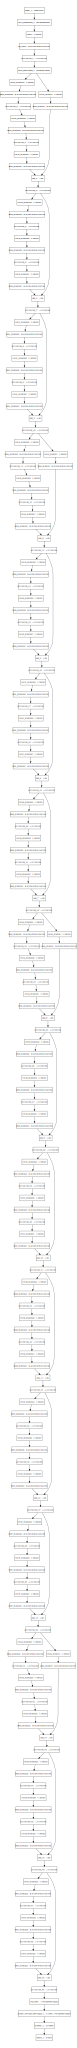

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import *

model = load_model("models/resnet50-mymodel.h5")
print("load successed")

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

* cam: 类激活图 7\*7
* P: 猫狗概率
* output: 卷积层的输出 2048\*1
* w: 卷积核的权重 7\*7\*2048

In [7]:
z = zip([x.name for x in model.layers], range(len(model.layers)))
for k, v in z:
    print("{} - {}".format(k,v))

input_1 - 0
zero_padding2d_1 - 1
conv1 - 2
bn_conv1 - 3
activation_1 - 4
max_pooling2d_1 - 5
res2a_branch2a - 6
bn2a_branch2a - 7
activation_2 - 8
res2a_branch2b - 9
bn2a_branch2b - 10
activation_3 - 11
res2a_branch2c - 12
res2a_branch1 - 13
bn2a_branch2c - 14
bn2a_branch1 - 15
add_1 - 16
activation_4 - 17
res2b_branch2a - 18
bn2b_branch2a - 19
activation_5 - 20
res2b_branch2b - 21
bn2b_branch2b - 22
activation_6 - 23
res2b_branch2c - 24
bn2b_branch2c - 25
add_2 - 26
activation_7 - 27
res2c_branch2a - 28
bn2c_branch2a - 29
activation_8 - 30
res2c_branch2b - 31
bn2c_branch2b - 32
activation_9 - 33
res2c_branch2c - 34
bn2c_branch2c - 35
add_3 - 36
activation_10 - 37
res3a_branch2a - 38
bn3a_branch2a - 39
activation_11 - 40
res3a_branch2b - 41
bn3a_branch2b - 42
activation_12 - 43
res3a_branch2c - 44
res3a_branch1 - 45
bn3a_branch2c - 46
bn3a_branch1 - 47
add_4 - 48
activation_13 - 49
res3b_branch2a - 50
bn3b_branch2a - 51
activation_14 - 52
res3b_branch2b - 53
bn3b_branch2b - 54
activati

http://docs.opencv.org/trunk/d3/d50/group__imgproc__colormap.html

![](http://docs.opencv.org/trunk/colorscale_jet.jpg)

In [8]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_heatmap_image(model_show, weights_show):
    plt.figure(figsize=(12, 14))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        img = cv2.imread('data0/test/test1/%d.jpg' % (100*i + 31))
        img = cv2.resize(img, (224, 224))
        x = img.copy()
        x.astype(np.float32)
        out, prediction = model_show.predict(np.expand_dims(x, axis=0))

        prediction = prediction[0]
        out = out[0]

        if prediction < 0.5:
            plt.title('cat %.2f%%' % (100 - prediction*100))
        else:
            plt.title('dog %.2f%%' % (prediction*100))

        cam = (prediction - 0.5) * np.matmul(out, weights_show)
        cam -= cam.min()
        cam /= cam.max()
        cam -= 0.2
        cam /= 0.8

        cam = cv2.resize(cam, (224, 224))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

        plt.axis('off')
        plt.imshow(out[:,:,::-1])
print("done")

done


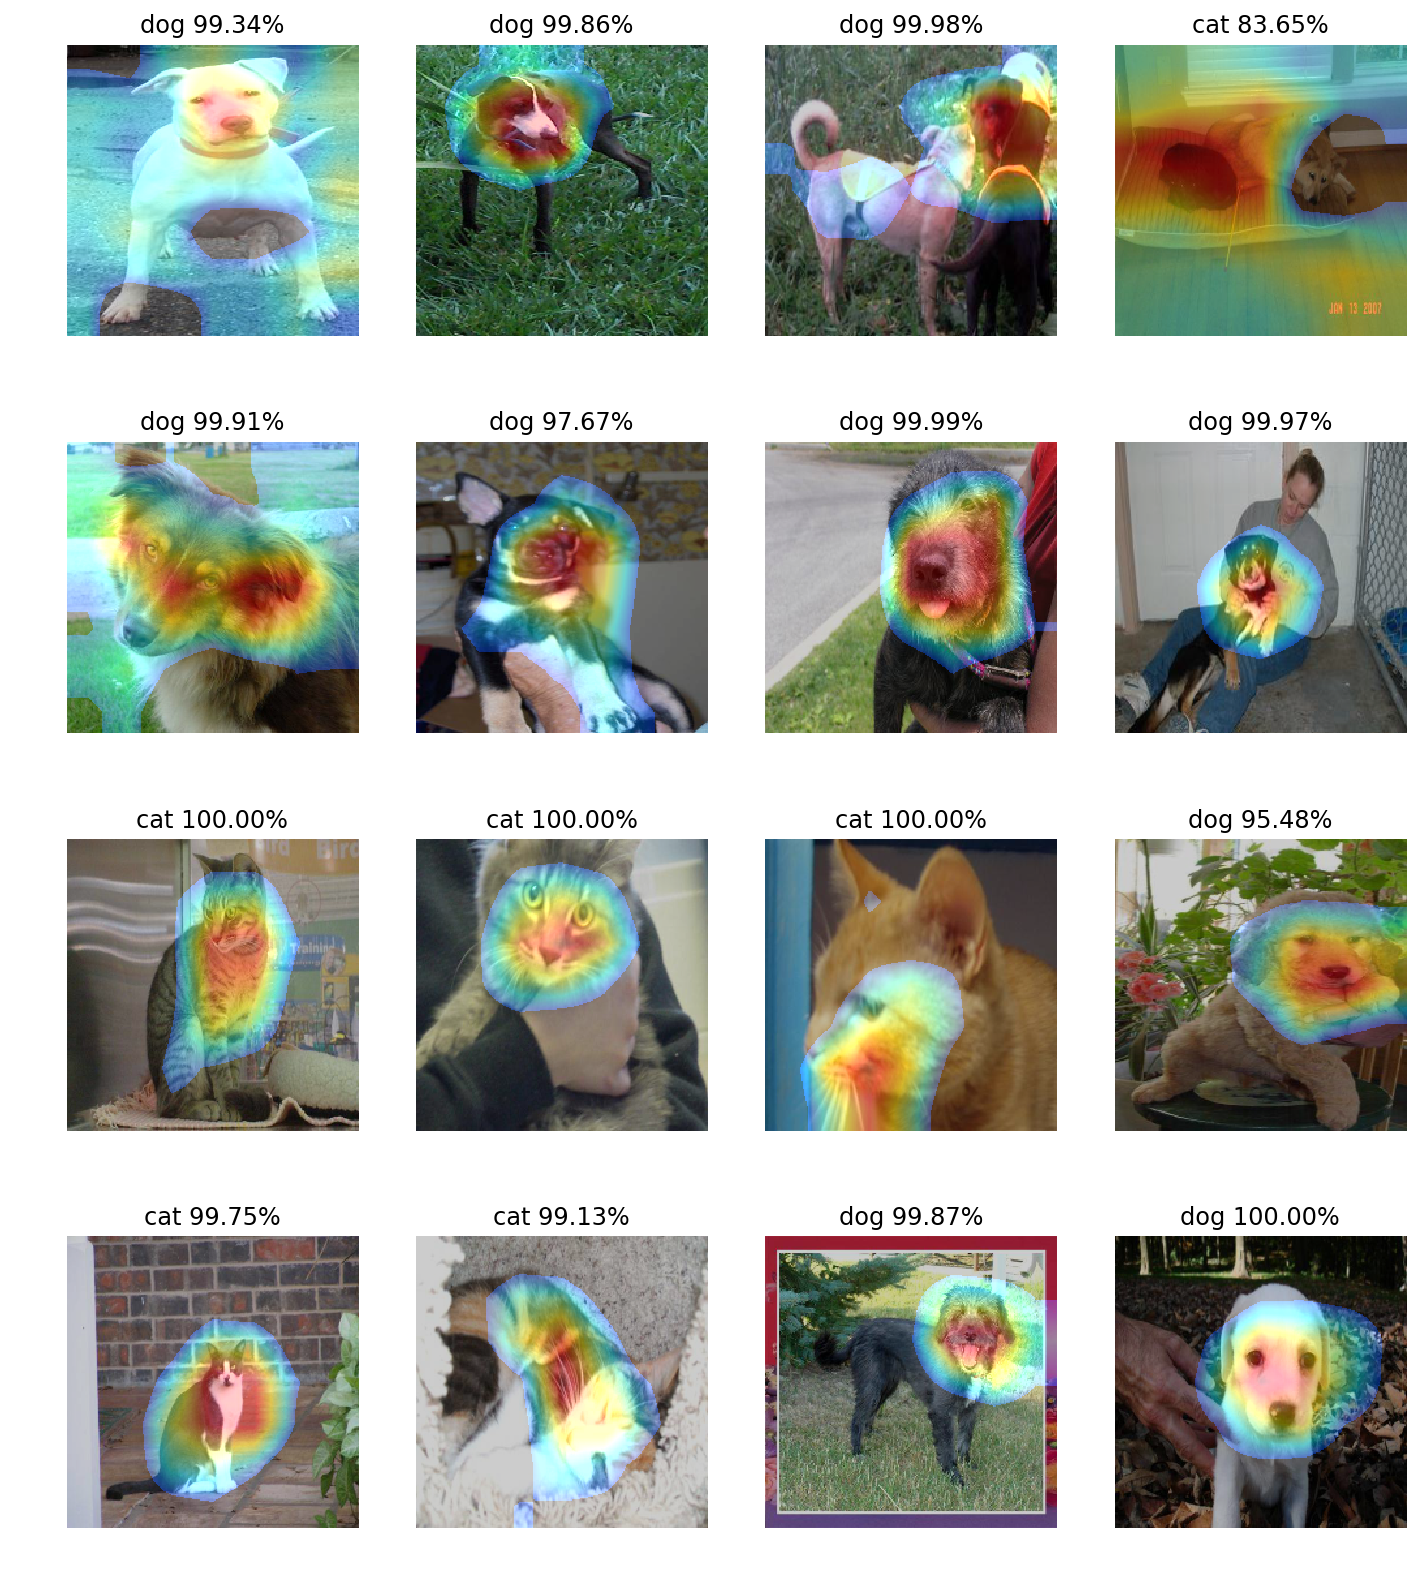

In [17]:
weights = model.layers[177].get_weights()[0]
model2 = Model(model.input, [model.layers[172].output, model.output])
show_heatmap_image(model2, weights)

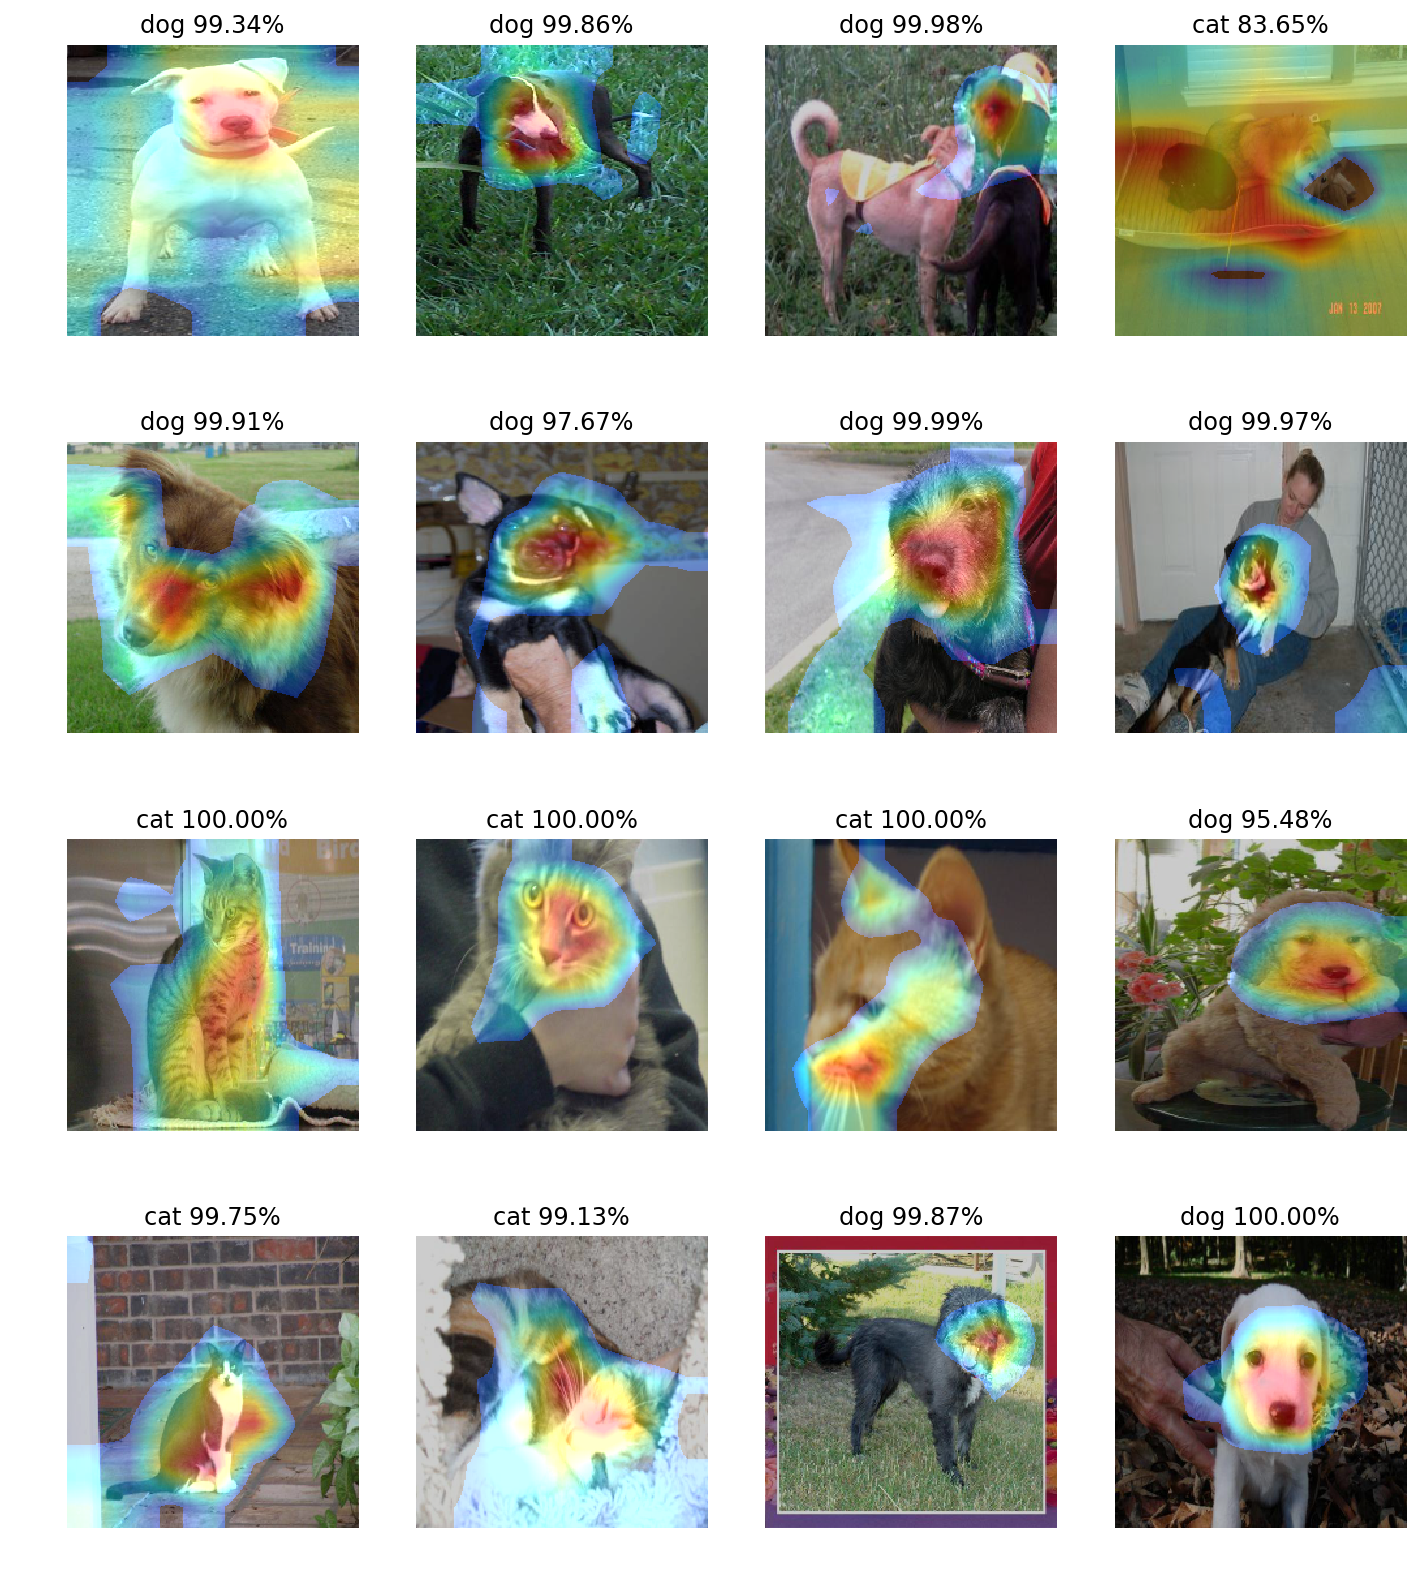

In [18]:
weights = model.layers[177].get_weights()[0]
model2 = Model(model.input, [model.layers[162].output, model.output])
show_heatmap_image(model2, weights)

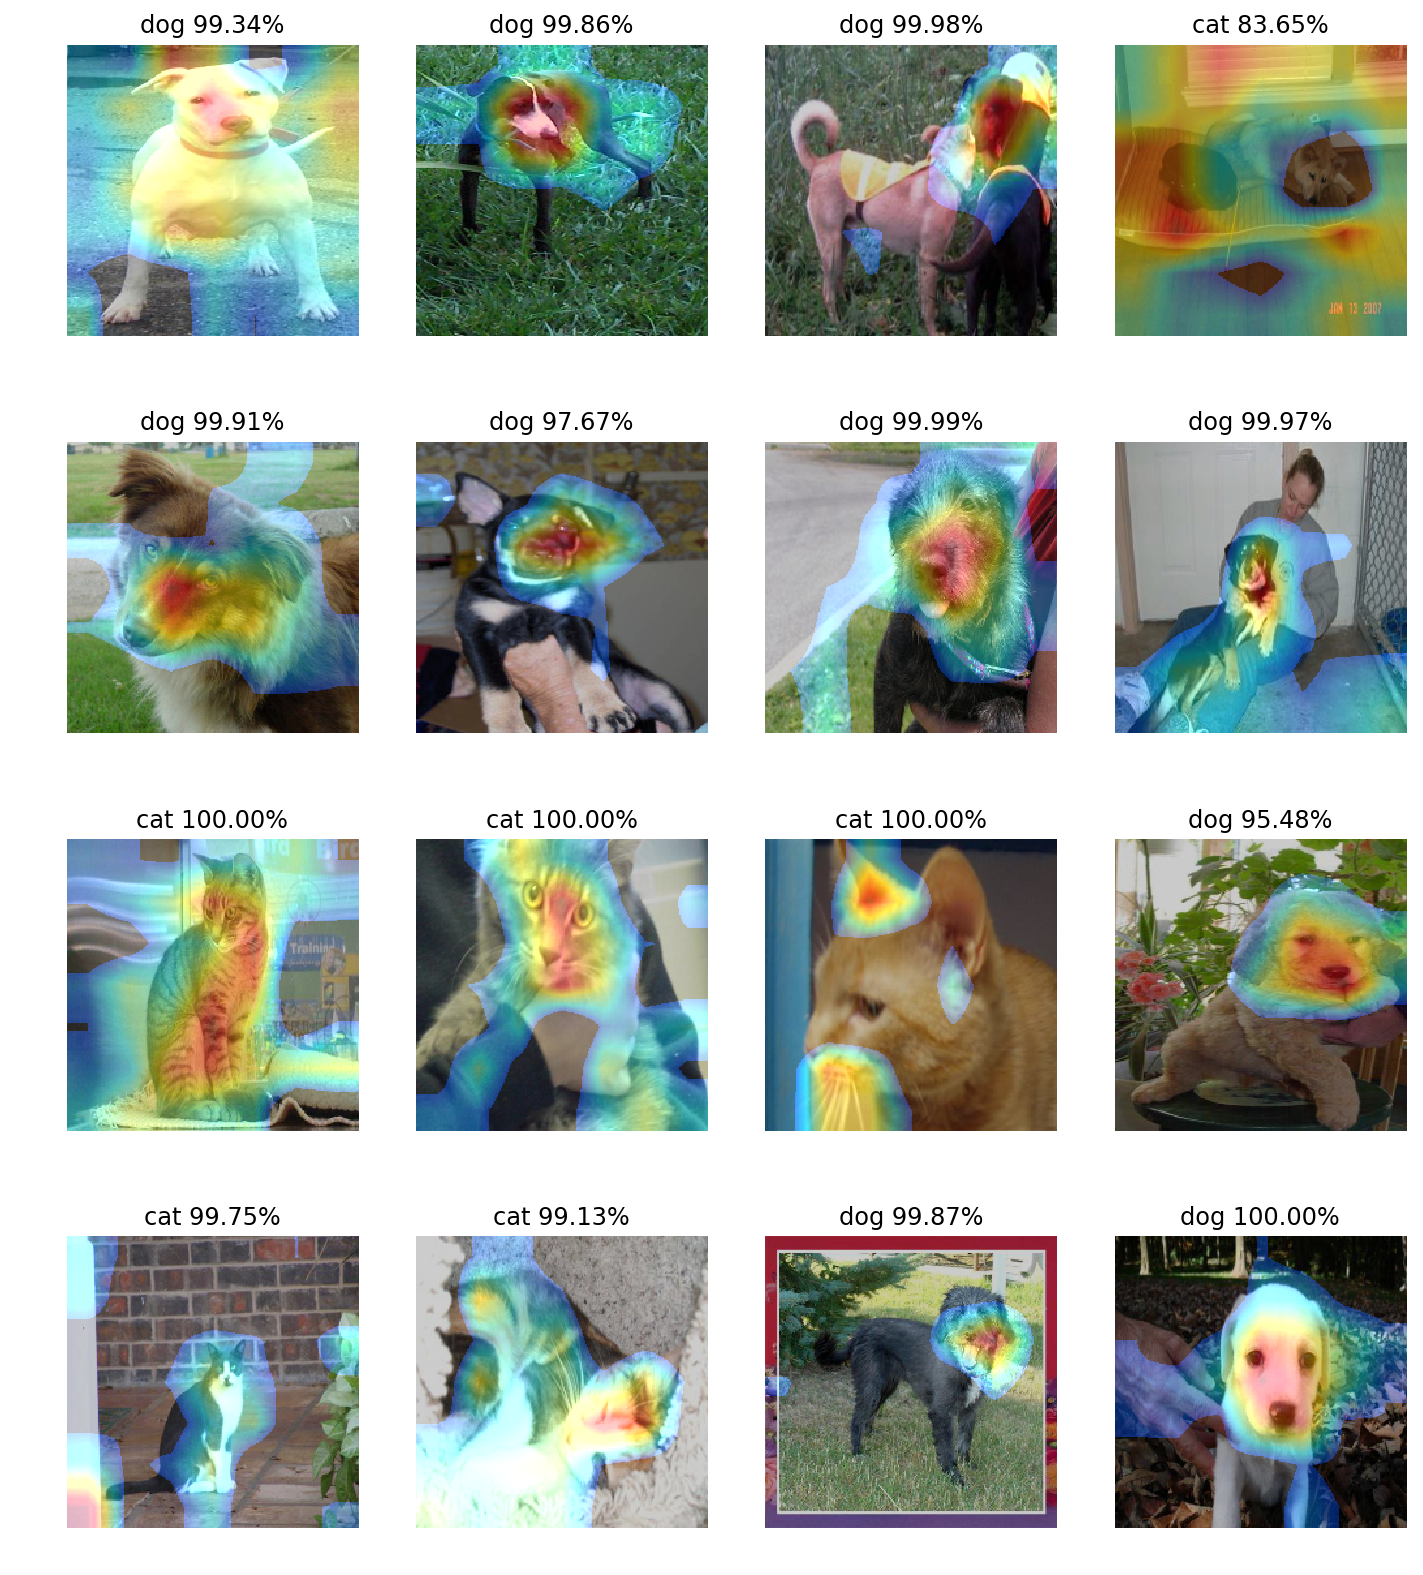

In [19]:
weights = model.layers[177].get_weights()[0]
model2 = Model(model.input, [model.layers[152].output, model.output])
show_heatmap_image(model2, weights)